# Introduction

In this lab we will follow along with the example of using word embeddings in the IMDB review sentiment analysis problem, in Chapter 6 of "Deep Learning with Python" by Chollet.

### Set runtime type
Change your runtime type to GPU in the Runtime > "Change runtime type" menu at the top of the page.

### Module imports

In [2]:
%tensorflow_version 1.x

from keras import layers
from keras import models
from keras import optimizers
import os
import time
from google.colab import drive
import matplotlib.pyplot as plt
import pickle
import math
import numpy as np

TensorFlow 1.x selected.


Using TensorFlow backend.


## Set up -- getting the data and word embeddings
I have shared the necessary files with you in the same Google drive folder we used for lab 9.  To get the data into colab, run the code cell below and click on the link that is displayed.  It will pop up a new browser tab where you have to authorize Colab to access your google drive.  Then, copy the sequence of numbers and letters that is displayed and paste it in the space that shows up in the code cell below.


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.mkdir("/content/stat344ne_imdb/")

In [0]:
!unzip -uq "/content/drive/My Drive/stat344ne_imdb/aclImdb.zip" -d "/content/stat344ne_imdb/data/"
!unzip -uq "/content/drive/My Drive/stat344ne_imdb/glove.6B.50d.txt.zip" -d "/content/stat344ne_imdb/glove/"

### Load word embeddings

We are working here with the GloVe (**Glo**bal **Ve**ctors for word representation) word embeddings.  The code for loading them is the same as in lab 9.

In [6]:
glove_dir = "/content/stat344ne_imdb/glove"

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Here is the first word in the embeddings dictionary and its encoding:

In [9]:
list(embeddings_index.items())[0]

('the', array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
       dtype=float32))

Here is the embedding of the word 'cat'.  It is a vector of 50 real numbers since we are working with embedding dimension 50.

Note that last class we used the notation `embeddings_index['cat']` to look up the embedding.  Using `.get('cat')` does the same thing, but is safer: if the word you're looking up is not in the `embeddings_index` dictionary, `get()` will return `None` but the square bracket notation would thrown an error.

In [18]:
embeddings_index.get('cat')

array([ 0.45281 , -0.50108 , -0.53714 , -0.015697,  0.22191 ,  0.54602 ,
       -0.67301 , -0.6891  ,  0.63493 , -0.19726 ,  0.33685 ,  0.7735  ,
        0.90094 ,  0.38488 ,  0.38367 ,  0.2657  , -0.08057 ,  0.61089 ,
       -1.2894  , -0.22313 , -0.61578 ,  0.21697 ,  0.35614 ,  0.44499 ,
        0.60885 , -1.1633  , -1.1579  ,  0.36118 ,  0.10466 , -0.78325 ,
        1.4352  ,  0.18629 , -0.26112 ,  0.83275 , -0.23123 ,  0.32481 ,
        0.14485 , -0.44552 ,  0.33497 , -0.95946 , -0.097479,  0.48138 ,
       -0.43352 ,  0.69455 ,  0.91043 , -0.28173 ,  0.41637 , -1.2609  ,
        0.71278 ,  0.23782 ], dtype=float32)

### Setting Up IMDB Data
I adapted the code in this section from Sections 6.1 through 6.3 of the book.  The code is described fairly well there and I encourage you to read through the description if you're curious.

Here's a brief overview:

 * You unzipped the imdb data set into a folder in Colab earlier.  Inside of that folder there is the following directory structure:
    * train
        * neg has the text of negative reviews for the training set
        * pos has the text of positive reviews for the training set
    * test
        * neg has the text of negative reviews for the test set
        * pos has the text of positive reviews for the test set
 * We loop through each example in the training set, read the text in and add it to a list of texts, and add the appropriate label indicator to a list of labels.

In [0]:
import os

imdb_dir = '/content/stat344ne_imdb/data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Here are the review texts in the data set.

In [11]:
texts

["Carlito Way, the original is a brilliant story about an ex-drug dealer who hopes to leave his criminal past and so he invests in a club and the deals with the trouble that comes with it.<br /><br />This film was....<br /><br />I saw the trailer and knew instantly it was going to be bad..But after dismissing films in the past and finding out they were great( Lucky Number Slevin, Tokyo Drift)...I gave this a shot and it failed within the first five minutes...<br /><br />The script is something a teenager would come up with if given five minutes to prepare...It was weak, with weaker dialogue. It seems there is an instant need for romance in a gangster movie. So Brigante decides to beat a guy up for the girl....and she say's 'Yes!' And if you need to act bad just throw racism around...As we learn from the 'Italian mobsters'...<br /><br />The acting was terrible to say the least...I found 'Hollywood Nicky', hilarious.<br /><br />I absolutely hate all these musicians turning to movies. Let

Now we convert the texts to a sparse encoding of the 10000 most common words in the text.  The less common words are represented using an `<Unknown>` token.  Keras provides a Tokenizer class that does this conversion to sparse encoding for us.

Recall that Keras requires each sequence to be the same length unless you use batch sizes of 1, or unless you write your own optimizer.  We set a maximum length of 500.  Longer reviews are truncated to the first 500 words, and shorter reviews are padded to be length 500 (we explored similar ideas in the dinosaur names lab).

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 500
training_samples = 10000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

np.random.seed(6375)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:(training_samples + validation_samples)]
y_val = labels[training_samples:(training_samples + validation_samples)]

Found 88582 unique tokens.
Shape of data tensor: (25000, 500)
Shape of label tensor: (25000,)


Here's what `x_train` looks like at this point.  Each row is a sparse encoding of words in one review.

In [13]:
x_train

array([[ 449,    6,    3, ...,   43,    4,  155],
       [   0,    0,    0, ...,  107, 8364, 1540],
       [   0,    0,    0, ...,   25,   74, 2798],
       ...,
       [   0,    0,    0, ...,  472,    3,  173],
       [   0,    0,    0, ...,   94,   98, 1440],
       [   0,    0,    0, ...,   15,   12,  548]], dtype=int32)

Here are the 20 most commonly occurring words in the data set and their sparse encodings:

In [14]:
list(word_index.items())[:20]

[('the', 1),
 ('and', 2),
 ('a', 3),
 ('of', 4),
 ('to', 5),
 ('is', 6),
 ('br', 7),
 ('in', 8),
 ('it', 9),
 ('i', 10),
 ('this', 11),
 ('that', 12),
 ('was', 13),
 ('as', 14),
 ('for', 15),
 ('with', 16),
 ('movie', 17),
 ('but', 18),
 ('film', 19),
 ('on', 20)]

I suspect that the word 'br' (number 7) is not actually a word in the reviews, but it is an artifact of buggy web scraping that was done to create the data set.

## Fitting Models

We are now reading to define and fit classification models for the data set.

### Using pre-trained GloVe embedding

We'll start by showing how to use the pre-trained GloVe embedding.  Fundamentally, this embedding just defines a special weight matrix in the network, the *embedding matrix*.  We'll see that in this example, using the pre-trained embedding actually doesn't have that great of performance.  In the next section, we'll estimate our own weights for the embedding matrix.

Note that our previous approach would have been to use a one-hot encoding of the word at each time point.  This would result in an array of shape (25000, 500, 10000) to store the one-hot encodings for 25000 training set examples padded to length 500 using a vocabulary size of 10000 words.  This approach isn't in the book, and I tried to add it -- but colab crashed because it ran out of memory.  The one-hot encoding is just infeasible to use in this example.

#### 1. Define embedding matrix

The first step is to set up an *embedding matrix* that is of shape (vocabulary size, embedding dimension).  Row $i$ of this matrix contains the embedding vector for word $i$ in the word index.

In the code below, I have set up a loop over the words and rows.  For example, the 17th word in the data set is 'movie'.  On that iteration of the loop, `i` will be equal to 17 and `word` will be equal to 'movie'.

In [0]:
# We are using an embedding dimension of 50.
embedding_dim = 50

# Create an embedding matrix.  To start, it is initialized to a matrix of all 0's.
# We will fill in the values in the loop below.
embedding_matrix = np.zeros((max_words, embedding_dim))

# Fill in embeddings.  Loop over all words in the data set
for word, i in word_index.items():
    # only encode the 10000 most common words in the data set
    if i < max_words:
        # Look up the embedding vector for word using embeddings_index.get(...)
        embedding_vector = embeddings_index.get(word)

        # Only try to fill in an embedding vector if GloVe actually had an
        # embedding for that word.  (If it didn't, that row will be all 0's)
        if embedding_vector is not None:
            # Set the appropriate row or column of the embedding_matrix to the
            # embedding_vector for this word.
            embedding_matrix[i, :] = embedding_vector

#### 2. Spot check that your code above worked correctly.

The code below shows that the 17th word in our data set is 'movie', and it looks up the GloVe embedding for the word 'movie'.

In [20]:
word_index['movie']

17

In [21]:
embeddings_index['movie']

array([ 0.30824 ,  0.17223 , -0.23339 ,  0.023105,  0.28522 ,  0.23076 ,
       -0.41048 , -1.0035  , -0.2072  ,  1.4327  , -0.80684 ,  0.68954 ,
       -0.43648 ,  1.1069  ,  1.6107  , -0.31966 ,  0.47744 ,  0.79395 ,
       -0.84374 ,  0.064509,  0.90251 ,  0.78609 ,  0.29699 ,  0.76057 ,
        0.433   , -1.5032  , -1.6423  ,  0.30256 ,  0.30771 , -0.87057 ,
        2.4782  , -0.025852,  0.5013  , -0.38593 , -0.15633 ,  0.45522 ,
        0.04901 , -0.42599 , -0.86402 , -1.3076  , -0.29576 ,  1.209   ,
       -0.3127  , -0.72462 , -0.80801 ,  0.082667,  0.26738 , -0.98177 ,
       -0.32147 ,  0.99823 ], dtype=float32)

Print out the row or column of the embedding matrix where the embedding vector for the word 'movie' should be.  Did the loop work?

In [22]:
embedding_matrix[17, :]

array([ 0.30824   ,  0.17223001, -0.23339   ,  0.023105  ,  0.28522   ,
        0.23075999, -0.41047999, -1.00349998, -0.20720001,  1.43270004,
       -0.80684   ,  0.68954003, -0.43647999,  1.10689998,  1.61070001,
       -0.31966001,  0.47744   ,  0.79395002, -0.84373999,  0.064509  ,
        0.90250999,  0.78609002,  0.29699001,  0.76056999,  0.433     ,
       -1.50320005, -1.64230001,  0.30256   ,  0.30770999, -0.87057   ,
        2.47819996, -0.025852  ,  0.50129998, -0.38593   , -0.15633   ,
        0.45522001,  0.04901   , -0.42598999, -0.86401999, -1.30760002,
       -0.29576001,  1.20899999, -0.3127    , -0.72461998, -0.80800998,
        0.082667  ,  0.26738   , -0.98176998, -0.32146999,  0.99822998])

#### Fit a RNN using the pre-trained GloVe embedding

I'm giving you the code to do this.

Note that although this `Embedding` layer is defined as part of the network, with this use it's almost better to think of it as a preprocessing step before our actual network begins with the hidden `Dense` layer.

We will not estimate the embedding parameters.  Instead, we will use the embeddings that are given to us as part of GloVe, and freeze those parameter estimates.  This is similar to what we did in the transfer learning example with the VGG16 network.

In [108]:
# Define network layers
rnn_glove_model = models.Sequential()
rnn_glove_model.add(layers.Embedding(max_features, 50))
rnn_glove_model.add(layers.SimpleRNN(32))
rnn_glove_model.add(layers.Dense(1, activation='sigmoid'))

# Set the weights for the embedding layer to our embedding matrix
rnn_glove_model.layers[0].set_weights([embedding_matrix])

# "Freeze" the weights for the embedding layer so they are not trainable
rnn_glove_model.layers[0].trainable = False

# Compile the model and run estimation.
rnn_glove_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
rnn_glove_history = rnn_glove_model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),
                    epochs=20,
                    batch_size=128)

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 15s 2ms/step - loss: 0.6917 - acc: 0.5487 - val_loss: 0.6831 - val_acc: 0.5681
Epoch 2/20
10000/10000 [==============================] - 12s 1ms/step - loss: 0.6648 - acc: 0.5999 - val_loss: 0.6603 - val_acc: 0.6063
Epoch 3/20
10000/10000 [==============================] - 12s 1ms/step - loss: 0.6365 - acc: 0.6379 - val_loss: 0.6183 - val_acc: 0.6620
Epoch 4/20
10000/10000 [==============================] - 12s 1ms/step - loss: 0.6125 - acc: 0.6718 - val_loss: 0.7208 - val_acc: 0.5888
Epoch 5/20
10000/10000 [==============================] - 12s 1ms/step - loss: 0.6062 - acc: 0.6768 - val_loss: 0.5978 - val_acc: 0.6839
Epoch 6/20
10000/10000 [==============================] - 12s 1ms/step - loss: 0.5971 - acc: 0.6857 - val_loss: 0.5914 - val_acc: 0.6973
Epoch 7/20
10000/10000 [==============================] - 12s 1ms/step - loss: 0.5901 - acc: 0.6952 - val_loss: 0.5923 - val_acc

Here's a plot of training and validaton set accuracy.  It's not great, but it's substantially better than random guessing.

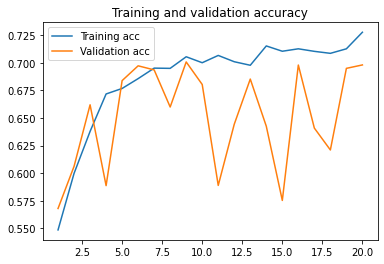

In [109]:
acc = rnn_glove_history.history['acc']
val_acc = rnn_glove_history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

#### 3. Estimating the Embedding Matrix

This time I'll ask you to do the code.  It's essentially the same as above, but you don't set the weights for he embedding layer or freeze those weights.

In [107]:
# Define a model with one embedding layer, a SimpleRNN layer,
# and a sigmoid activation for the output layer.
rnn_embed_model = models.Sequential()
rnn_embed_model.add(layers.Embedding(max_features, 50))
rnn_embed_model.add(layers.SimpleRNN(32))
rnn_embed_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model and run estimation.
rnn_embed_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
rnn_embed_history = rnn_embed_model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),
                    epochs=10,
                    batch_size=32)

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 59s 6ms/step - loss: 0.5724 - acc: 0.6993 - val_loss: 0.5224 - val_acc: 0.7544
Epoch 2/10
10000/10000 [==============================] - 55s 6ms/step - loss: 0.3489 - acc: 0.8562 - val_loss: 0.3704 - val_acc: 0.8463
Epoch 3/10
10000/10000 [==============================] - 56s 6ms/step - loss: 0.2598 - acc: 0.8995 - val_loss: 0.3890 - val_acc: 0.8555
Epoch 4/10
10000/10000 [==============================] - 55s 6ms/step - loss: 0.1799 - acc: 0.9327 - val_loss: 0.3829 - val_acc: 0.8494
Epoch 5/10
10000/10000 [==============================] - 55s 6ms/step - loss: 0.1226 - acc: 0.9563 - val_loss: 0.5327 - val_acc: 0.8225
Epoch 6/10
10000/10000 [==============================] - 55s 6ms/step - loss: 0.0697 - acc: 0.9761 - val_loss: 0.5858 - val_acc: 0.8125
Epoch 7/10
10000/10000 [==============================] - 55s 6ms/step - loss: 0.0394 - acc: 0.9877 - val_loss: 0.6718 - val_acc

You can just run the code below to make a plot of the training history.

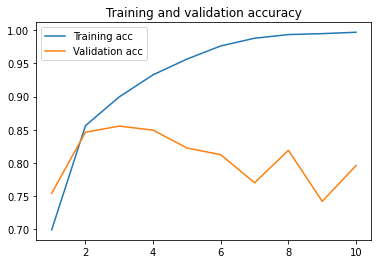

In [110]:
acc = rnn_embed_history.history['acc']
val_acc = rnn_embed_history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

This model is better.  Validation set accuracy of about 85% isn't fantastic -- but actually I think it's kindof amazing that a fundamentally simple model can do so well at text processing.

You could further refine the model if you wanted to (e.g. by trying GRU and/or LSTM layers, adding regularization, etc.).  But that's not necessary for this lab.